In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**AUDIO CLASSIFICATION USING ML**

**Introduction**

Audio classification is the process of classifying specific sounds into groups, such as speech
recognition and environmental sound categorization. Pitch recognition and music creation can
both benefit from audio machine learning. Convolutional neural networks are being used to
categorize images with high accuracy and at scale in recent developments in the field of image
classification. This raises the question of whether similar approaches could be used to classify
sounds in other domains.


**Problem Statement**

We will show how to use Supervised Machine Learning algorithm to categorize animal noises,specifically
identifying cats or dogs sounds.
We want to be able to detect if an audio sample with a few seconds of duration in a computer
readable format (like a .wav file) contains one of the target cat or dog sounds with a corresponding Classification Accuracy score. 


**Overview of the data set**

We will be using the "cats and dogs" audio data set. It consists of 277 sound files in 2 different classes, that is, cat and dog. There are 164 WAV
files in ”cat”,comprising 1323 seconds of audio.”dog” contains 113 WAV files with a total of
598 seconds of audio. 

The audio clips were created as digital audio files in the.wav format. When sound waves are
digitized, they are sampled at defined intervals, or sampling rate (samples are usually taken
44,100 times per second).It is our responsibility to take these files and extract various features,
then group the relevant audio recordings into the appropriate categories.

**Importing the necessary libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import os
#glob is use to list all the file in a directory
from glob import glob 

#The main package to work with audio data
import librosa 
import librosa.display

#to listen to sound
import IPython.display as ipd
from itertools import cycle

from sklearn import linear_model
import sklearn.metrics
from sklearn.preprocessing import scale, normalize

In [4]:
#For color and make my slide look nice

sns.set_theme(style='white', palette=None)
color_pal=plt.rcParams["axes.prop_cycle"].by_key()['color']
color_cycle=cycle(plt.rcParams["axes.prop_cycle"].by_key()['color'])

# Data exploration
We input audio into our notebook(Google Colab/Jupyter) as a numpy array for analysis
and manipulation thanks to Librosa, a Python tool for music and audio processing.
We will be able to utilize **Librosa’s load()** method to load the audio data for the preprocessing
because it flattens the audio channels into mono(signals recorded and played back using a single
audio channel), normalizes the data so the bit-depth values range between -1 and 1, and converts
the sampling rate to 22.05 KHz by default. Sampling rate  shows us how many samples are
recorded per second.

We use **glob** to return all file paths that match a specific pattern, that is. .wav files.


In [5]:
#We create a list containing the cat and dog audio
audio1=glob('../content/drive/MyDrive/Group_Assignment/cats_dogs/cats_dogs_split/cat/*.wav')
audio=glob('../content/drive/MyDrive/Group_Assignment/cats_dogs/cats_dogs_split/dog/*.wav')

In [6]:
#We play the first audio(Cat)
ipd.Audio(audio1[0])

In [7]:
#we listen the last audio (Dog)
ipd.Audio(audio[-1])

# Feature Extraction 
The next step is extracting the features that we will require to train our model. For this, we
will visually display some audio samples, allowing us to recognize features for classification.


In [8]:
#We extract the audio signal data and the sample rate of one audio
audio_data, audio_sr=librosa.load(audio1[0])
print('audio_data:',audio_data)
print(f'shape : {audio_data.shape}')
print(f'audio_sr:{audio_sr}')

audio_data: [ 0.00182185  0.00242155  0.0016865  ... -0.00101723  0.00033086
  0.        ]
shape : (321666,)
audio_sr:22050


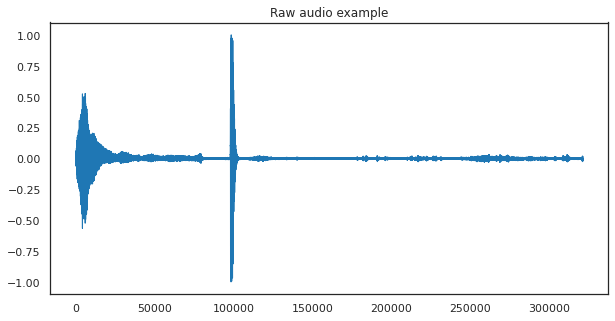

In [9]:
#We plot the wave function of our choosen audio
pd.Series(audio_data).plot(figsize=(10,5), lw=1, title='Raw audio example',
                 color=color_pal[0])
plt.show()

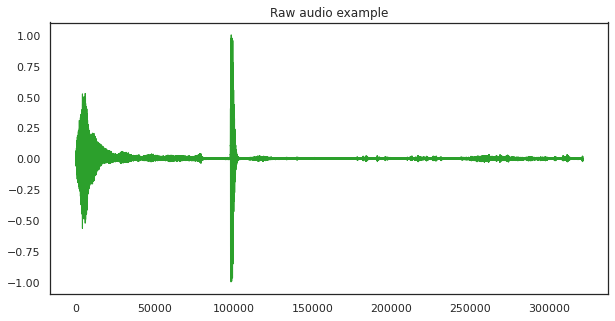

In [10]:
#We use trim to remove silence from our audio signal if there exists any
audio_data_trimed, _=librosa.effects.trim(audio_data)
pd.Series(audio_data_trimed).plot(figsize=(10,5), lw=1, title='Raw audio example',
                 color=color_pal[2])
plt.show()

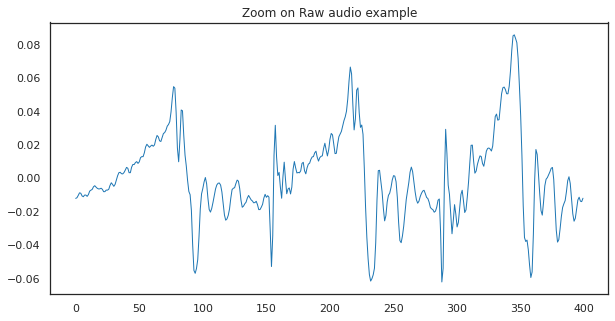

In [11]:
#We zoom on a portion of our audio signal
pd.Series(audio_data_trimed[100:500]).plot(figsize=(10,5), lw=1, 
                    title='Zoom on Raw audio example',
                 color=color_pal[0])
plt.show()

The discrete Fourier transforms (DFT) are computed over short overlapping windows to represent a signal in the time-frequency domain using the STFT. 

In [12]:
D=librosa.stft(audio_data)
s_db=librosa.amplitude_to_db(np.abs(D), ref=np.max)


In [13]:
#Shape 
s_db.shape

(1025, 629)

# Spectogram
Spectograms which are useful for visualising the spectrum of frequencies of the sounds
and their variation during a short period of time.

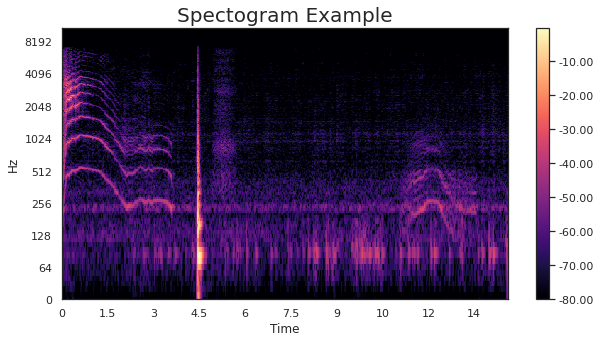

In [14]:
#Plot the transformed audio data spectogram 
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(s_db, x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [15]:
s=librosa.feature.melspectrogram(audio_data, sr=audio_sr, n_mels=128)
s_db_mel=librosa.amplitude_to_db(s, ref=np.max)

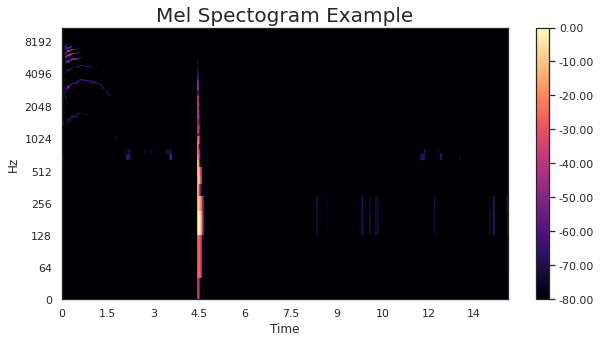

In [16]:
#We plot a spectogram presenting only the audible part of the audio file
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(s_db_mel, x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

# Data Preprocessing

## Mel-frequency-cepstral coefficient (MFCC) from audio sample
Extracts independent features from audiosignals.

We will extract an MFCC from each audio
file in the dataset and put it in a Panda Dataframe along with its classification label.We utilize
a loop through each row in the dataframe to extract all the features for each audio file.
The method to extract MFCC features will be called inside the loop, and we’ll establish a
unique file path for each file before calling it to append features. Librosa’s mfcc() function,
which creates an MFCC from time series audio data, will be used for this.

In [17]:
#We extract the mfc coeficients of our choosen audio and we look at it shape
mfccs= librosa.feature.mfcc(y=audio_data, sr=audio_sr, n_mfcc=40)  
mfccs.shape

(40, 629)

In [18]:
#We load our cat data, label then and and add them to an empty list we have created

#We create an empty list
extracted_features=[]
#We load all the cat audio data
audio_file=glob('/content/drive/MyDrive/Group_Assignment/cats_dogs/cats_dogs_split/cat/*.wav')

#For each cat audio, we extract the mfc coeficient and we label then as cat
for i in range(len(audio_file)):
    audio, sample_rate=librosa.load(audio_file[i], res_type='kaiser_best')
    mfccs_features= librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40) 
    mfccs_features_scale=np.mean(mfccs_features.T, axis=0)
    class_label='cat'
    data=mfccs_features_scale
    extracted_features.append([data,class_label])

#We load all the dog audios data  
audio_file=glob('/content/drive/MyDrive/Group_Assignment/cats_dogs/cats_dogs_split/dog/*.wav')

#For each dog audio, we extract the mfc coeficient and we label then as dog
for i in range(len(audio_file)):
    audio, sample_rate=librosa.load(audio_file[i], res_type='kaiser_best')
    mfccs_features= librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40) 
    mfccs_features_scale=np.mean(mfccs_features.T, axis=0)
    class_label='dog'
    data=mfccs_features_scale
    extracted_features.append([data,class_label])

In [19]:
#We create a data frame containg our mfc coefficient as feature and act or dog as label
Audio_data=pd.DataFrame(extracted_features, columns=['Features', 'Class'])
Audio_data

,Features,Class
0,"[-377.8122, 66.73977, 5.0269456, 15.146128, 4....",cat
1,"[-325.35233, 88.66885, -33.37905, 27.541372, 1...",cat
2,"[-218.74146, 183.47372, -61.297184, -13.291102...",cat
3,"[-397.47458, 24.06231, -53.82344, 42.322422, -...",cat
4,"[-215.92148, 121.48607, -70.094086, 40.772266,...",cat
...,...,...
272,"[-316.05032, 172.47577, -21.118689, -36.768913...",dog
273,"[-311.86505, 126.91018, -19.592947, -27.907839...",dog
274,"[-201.7342, 184.41676, -33.52283, -32.064247, ...",dog
275,"[-306.9651, 173.22382, -25.011309, -32.67598, ...",dog


#We randomly shuffle our dataframe


In [20]:
#We randomly shuffle our dataframe
data = Audio_data.sample(frac=1, random_state=1).reset_index()
data.drop('index', axis=1, inplace=True)
data

,Features,Class
0,"[-401.01434, 59.451435, -24.759964, -7.4936395...",dog
1,"[-279.0155, 109.46452, -25.593018, 60.32961, -...",cat
2,"[-308.02496, 108.01765, -15.544571, 40.891163,...",cat
3,"[-236.09242, 183.19301, -69.59084, -25.253294,...",dog
4,"[-284.29605, 134.32596, -27.582668, -4.133853,...",cat
...,...,...
272,"[-305.0146, 166.52646, -25.36159, -14.182473, ...",dog
273,"[-294.2264, 165.032, -22.025213, -19.49289, -1...",dog
274,"[-281.2993, 111.622055, -49.40886, 6.3382936, ...",cat
275,"[-308.95813, 166.56798, -11.959424, -32.813347...",dog


We convert the category text input into numerical data
that models can interpret.

In [21]:
#We replace 'cat' by 0 and 'dog' by 1 in our data frame in othe to have a numaric ouput
data['Class'].replace(to_replace=['cat'], value=0, inplace=True)
data['Class'].replace(to_replace=['dog'], value=1, inplace=True)

In [22]:
#We extract our feature matrix and we normalize it
X_matrix=normalize(np.array(data['Features'].tolist()))

#we extract our response variable containig the class of each audio feature
y_vector=np.array(data['Class'].tolist())

In [23]:
#We look at the shape of our feature matrix
X_matrix.shape

(277, 40)

We have 277 audio files with 40 features.

# Training and Splitting dataset

Sklearn.preprocessing will be used in splitting our data set.  We’ll use a random state of 0 and a 30 % testing set size.


In [24]:
#We split in training and testing set with 70% for training and 30% for testing
from sklearn.model_selection import train_test_split
X_train, X_test,Y_train,Y_test=train_test_split(X_matrix,y_vector, test_size=0.3, random_state=0)


# Model Creation
From the audio sample and split in the train and test sets, we have retrieved characteristics,
we can now build our model. We will implement a Support Vector Machine model and an ANN model.

# Suport Vector Machine

In [110]:
#We create an instance of our support vector machine with a linear kernel and a regularizer C=3000
from sklearn.svm import SVC
model = SVC(kernel='linear', C=6000)

In [111]:
#We fit our model using de training set
model.fit(X_train,Y_train)

SVC(C=6000, kernel='linear')

In [112]:
#We then compute the predicted value of our model using the trainig and testing set
y_pred_train  = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [113]:
#We load one of the cat sound and we check the prediction outcome
aud1=glob('/content/drive/MyDrive/Group_Assignment/cats_dogs/cats_dogs_split/cat/*.wav')
ipd.Audio(aud1[0])

In [114]:
#We predict wether is a cat or dog audio
audio, sample_rate=librosa.load(aud1[0], res_type='kaiser_best')
mfccs_features= librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40) 
mfccs_features_scale=np.mean(mfccs_features.T, axis=0)
x2=normalize(np.array(mfccs_features_scale.tolist()).reshape(1,40))
y=model.predict(x2)
y[0]

0

We observe that the model has correctly predicted that it is a cat's sound.

In [115]:
#We load one of the dog sound and we check the prediction outcome
aud1=glob('/content/drive/MyDrive/Group_Assignment/cats_dogs/cats_dogs_split/dog/*.wav')
ipd.Audio(aud1[0])

In [116]:
#We predict wether is a cat or dog audio
audio, sample_rate=librosa.load(aud1[0], res_type='kaiser_best')
mfccs_features= librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40) 
mfccs_features_scale=np.mean(mfccs_features.T, axis=0)
x2=normalize(np.array(mfccs_features_scale.tolist()).reshape(1,40))
y=model.predict(x2)
y[0]

1

We observe that the model has correctly predicted that it is a dog's sound.

In [117]:
#We compute the accuracy score of our model
import sklearn.metrics
#Training accuracy
sklearn.metrics.accuracy_score(y_pred_train , Y_train)

0.9740932642487047

In [118]:
#Testing accuracy
sklearn.metrics.accuracy_score(y_pred_test , Y_test)

0.7738095238095238

Here, we see that both the training and testing accuracy are within a good range. Therefore the model is good.

#Confusion Matrix
A confusion matrix aids in visualizing the results of a classification problem by providing a table layout of the various outcomes of the prediction and findings.
It creates a table with all of a classifier's predicted and actual values. 

In [119]:
#Confusion matrix for training
sklearn.metrics.confusion_matrix(Y_train,y_pred_train) 

array([[107,   3],
       [  2,  81]])

From the above output, we observe that:

True Positives (Cat) = 107

True Negatives (Dog) = 81

False Positives (Says Cat(0) when it's dog) = 3

False Negatives (Says Dog(1) when it's a cat) = 2

In [120]:
#Confusion matrix for testing
sklearn.metrics.confusion_matrix(Y_test,y_pred_test)

array([[42, 12],
       [ 7, 23]])

From the above output, we observe that:

True Positives (Cat) = 42

True Negatives (Dog) = 23

False Positives (Says Cat(0) when it's a dog) = 12

False Negatives (Says Dog(1) when it's a cat) = 7

In [121]:
#F1 score for training
sklearn.metrics.f1_score(Y_train,y_pred_train)

0.970059880239521

Harmonic mean of precision and recall.

The model is more accurate as it is closer it is to 1. 

In [122]:
#F1 score for testing
sklearn.metrics.f1_score(Y_test,y_pred_test)

0.7076923076923077

In [123]:
#Recall score for training
sklearn.metrics.recall_score(Y_train,y_pred_train)

0.9759036144578314

Recall is used to calculate the model's ability to predict positive values. "How often does the model predict the correct positive values?".

The model's ability to predict positive values is 97%.

In [124]:
#Recall score for testing
sklearn.metrics.recall_score(Y_test,y_pred_test)

0.7666666666666667

The model's ability in the test to predict positive values is 76%.

In [125]:
#Precision score for training
sklearn.metrics.precision_score(Y_train,y_pred_train)

0.9642857142857143

Precision is used to calculate the model's ability to classify positive values correctly.
It's precision is 96% in the training.

In [126]:
#Precision score for testing
sklearn.metrics.precision_score(Y_test,y_pred_test)

0.6571428571428571


It's precision is 66% in testing.

# Artificial Neural Network (ANN)

We will implement an ANN model using Keras sequential API. 

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras import metrics
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import plot_model,to_categorical
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder


In [43]:
#We split in training and testing set with 70% for trainig and 30% for testing
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y_vector1 = to_categorical(le.fit_transform(y_vector))
X_train_NN, X_test_NN,Y_train_NN,Y_test_NN=train_test_split(X_matrix,y_vector1, test_size=0.3, random_state=0)

The number of classes is 2, which is our output shape(number of classes), and we will create ANN with 2 dense layers and architecture is explained below.

The first layer has 20 neurons. Input shape is 40 according to the number of features with activation function as Relu.

The second layer has 30 neurons with activation function as Relu.

To compile the model,we define loss function which is a categorical cross-entropy, accuracy metrics which is accuracy score, and an optimizer which is Adam.
    



In [44]:
def network():
  
    # Seeting a seed so we can reproduce the results
    tf.random.set_seed(137)

    # Define the initialisation method
    initializer = RandomNormal(mean = 0.0, stddev=0.01)

    # create a squential model
    model = Sequential()

    # add fully connected layer
    model.add(Dense(20, input_dim=40, activation='relu', kernel_initializer = initializer))
    model.add(Dense(30, activation='relu', kernel_initializer = initializer))

    # add one fully connected output layer with a softmax activation
    model.add(Dense(2, activation='softmax', kernel_initializer = initializer))

    # Define the optimiser
    optimiser = Adam(learning_rate=0.001)

    # Define the loss function
    loss = CategoricalCrossentropy()
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimiser, 
                  metrics=['accuracy'])
    
    return model

## Model Summary 

In [85]:
model1=network()
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 20)                820       
                                                                 
 dense_10 (Dense)            (None, 30)                630       
                                                                 
 dense_11 (Dense)            (None, 2)                 62        
                                                                 
Total params: 1,512
Trainable params: 1,512
Non-trainable params: 0
_________________________________________________________________


# Train the Model


In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
history1 = model1.fit(X_train_NN, Y_train_NN,epochs=200)

In [88]:
y_pred_train_NN = np.argmax(model1.predict(X_train_NN), axis=-1)
y_pred_test_NN = np.argmax(model1.predict(X_test_NN), axis=-1)

3/3 [==============================] - 0s 3ms/step


# Check the Accuracy

In [89]:
sklearn.metrics.accuracy_score(np.argmax(Y_train_NN,axis=-1), y_pred_train_NN)

0.9585492227979274

Accuracy score for training is 95% which is good.

In [90]:
sklearn.metrics.accuracy_score(np.argmax(Y_test_NN,axis=-1), y_pred_test_NN)

0.7976190476190477

Accuracy score for testing is 80%.

In [91]:
sklearn.metrics.f1_score(np.argmax(Y_train_NN,axis=-1), y_pred_train_NN)

0.9512195121951219

In [92]:
sklearn.metrics.f1_score(np.argmax(Y_test_NN,axis=-1), y_pred_test_NN)

0.7213114754098361

The f1 score is close to 1 implying that themodel is better.

In [93]:
sklearn.metrics.recall_score(np.argmax(Y_train_NN,axis=-1), y_pred_train_NN)

0.9397590361445783

The model's ability to predict positive values is 94% in training.

In [94]:
sklearn.metrics.recall_score(np.argmax(Y_test_NN,axis=-1), y_pred_test_NN)

0.7333333333333333

The model's ability to predict positive values is 73% in testing.

In [95]:
sklearn.metrics.precision_score(np.argmax(Y_train_NN,axis=-1), y_pred_train_NN)

0.9629629629629629

Precision is used to calculate the model's ability to classify positive values correctly. It's precision is 96% in the training.

In [96]:
sklearn.metrics.precision_score(np.argmax(Y_test_NN,axis=-1), y_pred_test_NN)

0.7096774193548387

Precision is used to calculate the model's ability to classify positive values correctly. It's precision is 71% in the testing.

# Conclusion

After performing both the deep learning and SVM on the data set o Audio and Dogs, we were able to build a machine learning model which could predict if the given sound was a cat or a Dog's. That is, we have the table as follows 
	The SVM
\[\begin{array}{|l|c|c|c|c|}
	\hline 
	&Accuracy & Recall& F1 & Precision\\
	\hline
	Training&0.97&0.97&0.97&0.96\\
	\hline
	Testing&0.77&0.76&0.71&0.66\\
	\hline
\end{array}\]
for ANN
\[\begin{array}{|l|c|c|c|c|}
	\hline 
	&Accuracy & Recall& F1 & Precision\\
	\hline
	Training&0.96&0.94&0.95&0.96\\
	\hline
	Testing&0.80&0.73&0.72&0.71\\
	\hline
\end{array}\]
Looking at the table, we see that the In training, both models perform very similar to each other, but the ANN performs better in testing more than the SVM.